# TDOA positioning example using generalized cross correlations

This example shows how to load a speech signal and simulate sound wave propagation in a virtual room using pyroomacoustics. By creating a room with several microphones, we can then used GCC-PHAT or a pre-trained NGCC-PHAT model to estimate the TDOAs between microphone pairs. The TDOA measurements can then be used to position the sound source. 

In [1]:
import numpy as np
import torch
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import random
from model import GCC, NGCCPHAT
from scipy.optimize import minimize

# for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


### Load the sample speech signal

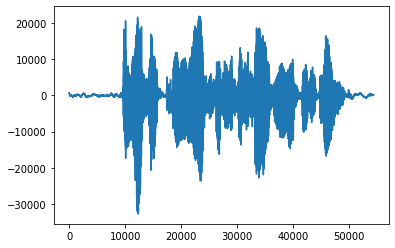

In [2]:

filename = "speech.wav"
fs, signal = wavfile.read(filename)
signal = np.array(signal)

plt.plot(signal)
                          
# listen to the speech signal
Audio(filename)

### Create a virtual room with 3 microphones and a single sound source

/home/axel/anaconda3/envs/py37/lib/python3.7/site-packages/pyroomacoustics/room.py:1525: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = a3.Axes3D(fig)


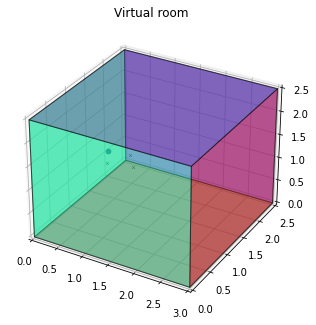

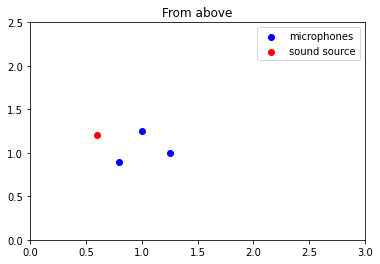

The true TDOAs are [14.904648298093212, 12.919446671572926, -1.9852016265202852]


In [3]:
# Test room parameters
room_dim= [3.0, 2.5, 2.5]
t60 = 0.6 #seconds
snr = 10 # dB

# Microphone locations
mic_locs = np.array([[1.25, 1.0, 1.25], [0.80, 0.90, 1.25], [1.0, 1.25, 1.25]]).T

# Sound source position at the same hight
source_loc = np.array([0.60, 1.20, 1.25])

# Create the virtual room
e_absorption, max_order = pra.inverse_sabine(t60, room_dim)

room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(
    e_absorption), max_order=max_order)

c = room.c #speed of sound

room.add_source(source_loc, signal=signal)
room.add_microphone(mic_locs)

fig, ax = room.plot()
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]])
plt.title('Virtual room')
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(mic_locs[0], mic_locs[1], c='b', label='microphones')
ax.scatter(source_loc[0], source_loc[1], c='r', label='sound source')
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
plt.title('From above')
plt.legend()
plt.show()

# Calculate the true TDOA 
delays = []
for pairs in [[0, 1], [0, 2], [1, 2]]:
    d = np.sqrt(np.sum((mic_locs[:, pairs[0]] - source_loc)**2)) - np.sqrt(np.sum((mic_locs[:, pairs[1]] - source_loc)**2))
    delays.append(d * fs / c)

print("The true TDOAs are " + str(delays))


### Plot the room impulse response for each microphone

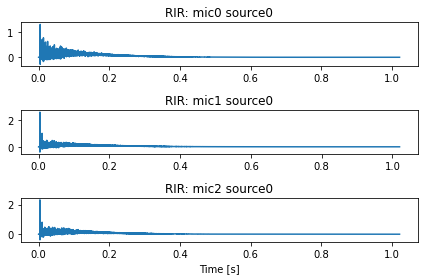

In [4]:
room.plot_rir()

### Simulate room sound propagation

torch.Size([3, 2048])


Text(0.5, 1.0, 'Signal received at mic 0')

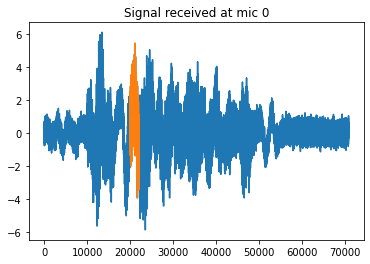

In [5]:
room.simulate(snr=snr)

y = room.mic_array.signals
plt.plot(y[0])

# Pick a 2048 samples long snippet
sig_len = 2048
start_idx = 20000
end_idx = start_idx + sig_len

x = torch.Tensor(y[:, start_idx:end_idx])
print(x.shape)
plt.plot(range(start_idx,end_idx), x[0].squeeze())
plt.title("Signal received at mic 0")

### Perform TDOA estimation using GCC-PHAT and a pre-trained NGCC-PHAT network

In [6]:
# Load the GCC-PHAT and NGCC-PHAT modules for TDOA estimation

max_tau = 23
gcc = GCC(max_tau)
ngcc = NGCCPHAT(max_tau, 'classifier', True, sig_len, 128, fs)

# Load the model weights
ngcc.load_state_dict(torch.load(
        "experiments/ngccphat/model.pth", map_location=torch.device('cpu')))
ngcc.eval()

NGCCPHAT(
  (backbone): SincNet(
    (conv): ModuleList(
      (0): SincConv_fast()
      (1): Conv1d(128, 128, kernel_size=(11,), stride=(1,))
      (2): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
      (3): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
    )
    (bn): ModuleList(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    )
    (ln): ModuleList()
    (act): ModuleList(
      (0): LeakyReLU(negative_slope=0.2)
      (1): LeakyReLU(negative_slope=0.2)
      (2): LeakyReLU(negative_slope=0.2)
      (3): LeakyReLU(negative_slope=1)
    )
    (drop): ModuleList(
      (0): Dropout(p=0.0, inplace=False)
      (1): Dropout(p=0.0, inplace=False)
      (2): D

### Compute the cross-correlation and probability distribution

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


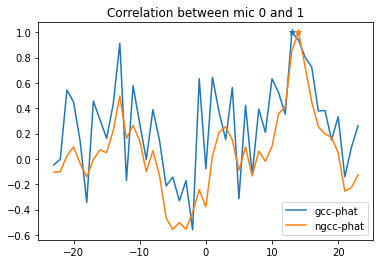

True TDOA (in samples): 14.904648298093212
GCC-PHAT estimate: 13.0
NGCC-PHAT estimate: 14.0


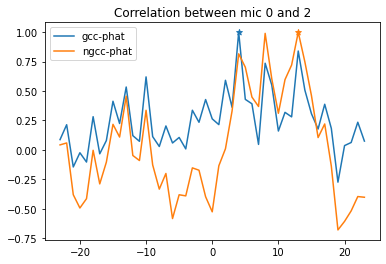

True TDOA (in samples): 12.919446671572926
GCC-PHAT estimate: 4.0
NGCC-PHAT estimate: 13.0


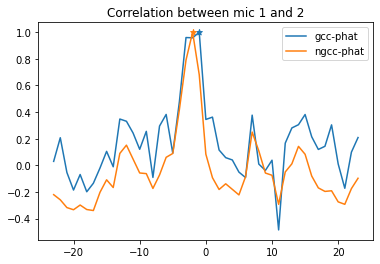

True TDOA (in samples): -1.9852016265202852
GCC-PHAT estimate: -1.0
NGCC-PHAT estimate: -2.0


In [7]:
gcc_delays = []
ngcc_delays = []
for i, pairs in enumerate([[0, 1], [0, 2], [1, 2]]):
    
    x1 = x[pairs[0]].unsqueeze(0)
    x2 = x[pairs[1]].unsqueeze(0)
    cc = gcc(x1, x2).squeeze()
    cc = cc / torch.max(cc)
    p = ngcc(x1, x2).squeeze()
    p = p.detach()
    p = p / torch.max(p)

    inds = range(-max_tau, max_tau+1)
    plt.figure()
    plt.plot(inds, cc, label='gcc-phat')
    plt.plot(inds, p, label='ngcc-phat')
    plt.legend()

    shift_gcc = float(torch.argmax(cc, dim=-1)) - max_tau
    shift_ngcc = float(torch.argmax(p, dim=-1)) - max_tau
    
    gcc_delays.append(shift_gcc)
    ngcc_delays.append(shift_ngcc)

    plt.scatter(shift_gcc, 1.0, marker='*')
    plt.scatter(shift_ngcc, 1.0, marker='*')
    plt.title("Correlation between mic " + str(pairs[0]) + " and " + str(pairs[1]))
    plt.show()

    print("True TDOA (in samples): " + str(delays[i]))
    print("GCC-PHAT estimate: " + str(shift_gcc))
    print("NGCC-PHAT estimate: " + str(shift_ngcc))

### Find the source position using multilateration

Now that we have estimated the TDOAs, we can estimate the sound source position using multilateration. Since we have put the source at the same height as the microphones, we can do this in 2D by solving for the $(x,y)$-coordinates.

Let $\mathbf{x} \in \mathbb{R}^2$ denote the unknown source coordinates, $\mathbf{m}_0, \mathbf{m}_1, \mathbf{m}_2 \in \mathbb{R}^2$ the microphone coordinates and $\tau_{ij}$ be the ground truth delays. The following then holds:

$||\mathbf{x} - \mathbf{m}_i|| - ||\mathbf{x} - \mathbf{m}_j|| = c\tau_{ij}$

where $c$ is the speed of sound. Given our measurements, we can find an approximate solution by minimizing the squared error over all measurements

$\hat{\mathbf{x}} = \text{arg min}_\mathbf{x} \sum_{i,j} (||\mathbf{x} - \mathbf{m}_0|| - ||\mathbf{x} - \mathbf{m}_i|| -\tau_{ij} )^2 $ 

In [8]:
# Compute the source location using multilateration

def loss(x, mic_locs, tdoas):
    return sum([(np.linalg.norm(x - mic_locs[:, pairs[0]]) - \
                   np.linalg.norm(x - mic_locs[:, pairs[1]]) - \
                   tdoas[i] / fs * room.c) ** 2 for i, pairs in enumerate([[0, 1], [0, 2], [1, 2]])])

guess = [0, 0]
bounds = ((0, room_dim[0]), (0, room_dim[1]))
xhat_gcc = minimize(loss, guess, args=(mic_locs[:2], gcc_delays), bounds=bounds).x
xhat_ngcc = minimize(loss, guess, args=(mic_locs[:2], ngcc_delays), bounds=bounds).x

print("Grount truth position: " + str(source_loc[:2]))
print("GCC estimate: " + str(xhat_gcc))
print("NGCC estimate: " + str(xhat_ngcc))

Grount truth position: [0.6 1.2]
GCC estimate: [0.86870156 1.04751231]
NGCC estimate: [0.64771617 1.18440341]


We can also visualize the solution as intersection between hyperbolas

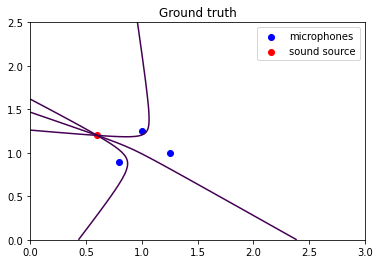

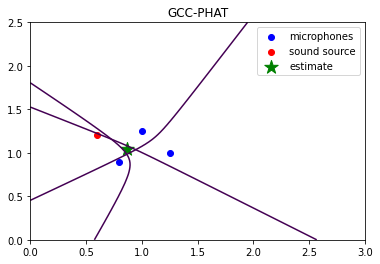

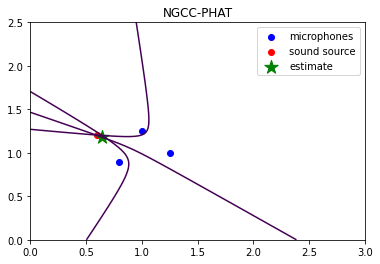

In [9]:
xx = np.linspace(0, room_dim[0], 100)
yy = np.linspace(0, room_dim[1], 100)
xx, yy = np.meshgrid(xx, yy)

def plot_hyperbolas(tdoas, name, estimate=None):
    fig = plt.figure()
    ax = fig.add_subplot()
    for i, pairs in enumerate([[0, 1], [0, 2], [1, 2]]):

        plt.contour(xx, yy, (np.sqrt((xx-mic_locs[0, pairs[0]])**2 + (yy-mic_locs[1, pairs[0]])**2) 
             - np.sqrt((xx-mic_locs[0, pairs[1]])**2 + (yy-mic_locs[1, pairs[1]])**2) 
             - tdoas[i] / fs * room.c), [0])

    ax.scatter(mic_locs[0], mic_locs[1], c='b', label='microphones')
    ax.scatter(source_loc[0], source_loc[1], c='r', label='sound source')
    if estimate is not None:
        ax.scatter(estimate[0], estimate[1], c='g', label='estimate', marker='*', s=200)
    ax.set_xlim([0, room_dim[0]])
    ax.set_ylim([0, room_dim[1]])
    plt.title('From above')
    plt.legend()
    plt.title(name)
    plt.show()
    
plot_hyperbolas(delays, 'Ground truth')
plot_hyperbolas(gcc_delays, 'GCC-PHAT', xhat_gcc)
plot_hyperbolas(ngcc_delays, 'NGCC-PHAT', xhat_ngcc)
